## Предобработка данных и поиск ассоциаций


Ядро - R

In [1]:
library(SNPRelate)
library(data.table)
library(qqman)

vcf.fn <- "test_data.vcf"
gds.fn <- "test_data.gds"
snpgdsVCF2GDS(vcf.fn, gds.fn, method = "biallelic.only", verbose = TRUE)
genofile <- snpgdsOpen(gds.fn)

phenos <- fread("test_data.tsv")
sample.ids <- read.gdsn(index.gdsn(genofile, "sample.id"))
common.samples <- intersect(sample.ids, phenos$sample)



Загрузка требуемого пакета: gdsfmt

SNPRelate -- supported by Streaming SIMD Extensions 2 (SSE2)



For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.





Start file conversion from VCF to SNP GDS ...
Method: extracting biallelic SNPs
Number of samples: 153
Parsing "test_data.vcf" ...
	import 11587 variants.
+ genotype   { Bit2 153x11587, 432.8K } *
Optimize the access efficiency ...
Clean up the fragments of GDS file:
    open the file 'test_data.gds' (475.0K)
    # of fragments: 47
    save to 'test_data.gds.tmp'
    rename 'test_data.gds.tmp' (474.7K, reduced: 324B)
    # of fragments: 20


Всего 153 образца и 11587 SNP. 99 образцов имеют данные о фенотипе, фильтруем vcf только по этим образцам.

In [2]:

phenos.filtered <- phenos[match(common.samples, phenos$sample), ]
geno.mat <- snpgdsGetGeno(genofile, sample.id = common.samples)
#geno.mat <- t(geno.mat)  

snp.ids <- read.gdsn(index.gdsn(genofile, "snp.id"))
geno.df <- as.data.frame(geno.mat)
colnames(geno.df) <- snp.ids
rownames(geno.df) <- phenos.filtered$sample

y <- as.numeric(phenos.filtered$phenotype)


Genotype matrix: 99 samples X 11587 SNPs


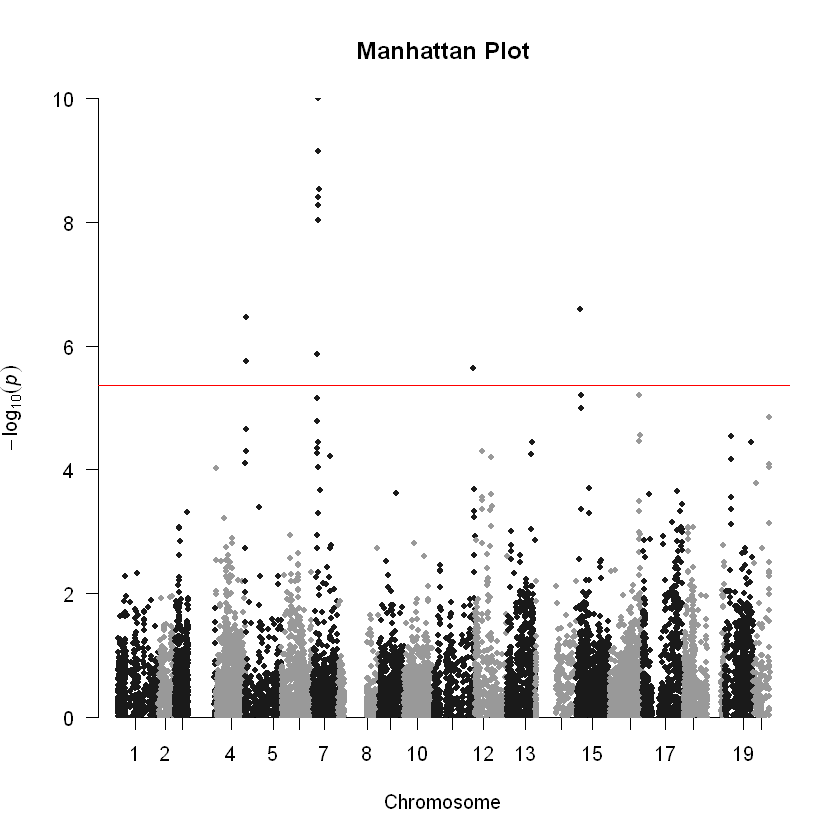

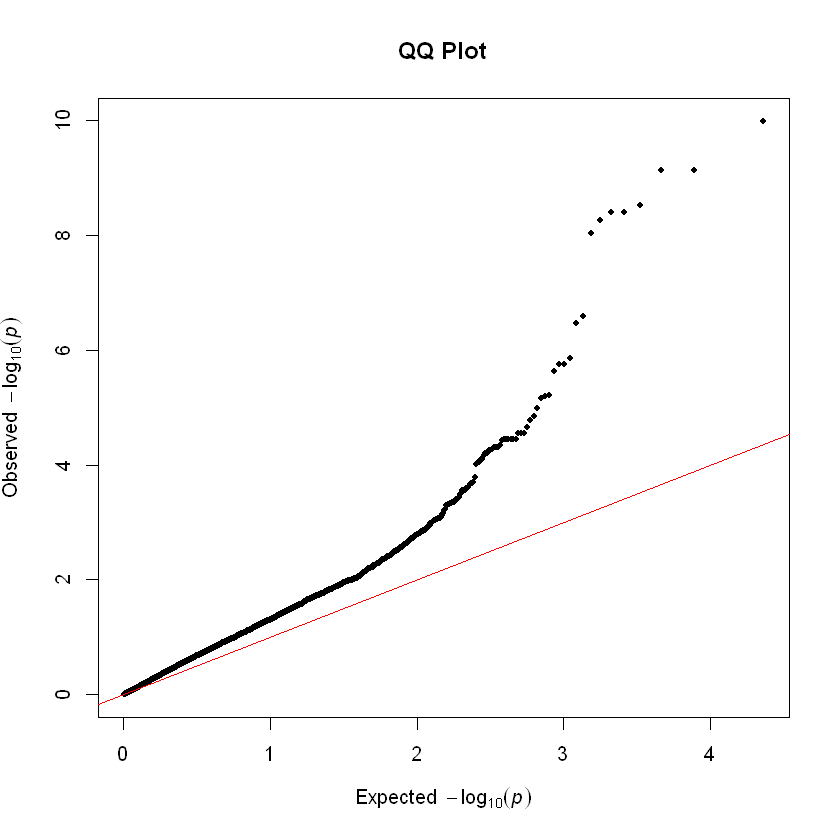

In [8]:

n.snp <- ncol(geno.df)
gwas_results <- data.frame(SNP = colnames(geno.df), beta = NA_real_, pvalue = NA_real_, stringsAsFactors = FALSE)

for (i in 1:n.snp) {
  snp_geno <- geno.df[[i]]
  if (sd(snp_geno, na.rm = TRUE) == 0) next
  model <- lm(y ~ snp_geno)
  coef_summary <- summary(model)$coefficients
  gwas_results$beta[i] <- coef_summary[2, "Estimate"]
  gwas_results$pvalue[i] <- coef_summary[2, "Pr(>|t|)"]
}

gwas_results <- na.omit(gwas_results)
gwas_results <- gwas_results[order(gwas_results$pvalue), ]
write.csv(gwas_results, "gwas_results.csv", row.names = FALSE)

gwas_results$logP <- -log10(gwas_results$pvalue)

snp.chrom <- read.gdsn(index.gdsn(genofile, "snp.chromosome"))
snp.bp <- read.gdsn(index.gdsn(genofile, "snp.position"))
snp.info <- data.frame(SNP = snp.ids, CHR = as.numeric(snp.chrom), BP = as.numeric(snp.bp), stringsAsFactors = FALSE)

manhattan_df <- merge(gwas_results, snp.info, by = "SNP")

manhattan(manhattan_df, chr = "CHR", bp = "BP", snp = "SNP", p = "pvalue", main = "Manhattan Plot", genomewideline = -log10(0.05 / nrow(manhattan_df)), suggestiveline = FALSE)
qq(manhattan_df$pvalue, main = "QQ Plot")

snpgdsClose(genofile)

По графикам видим, что действительно есть ассоциации, особенно на хромооме 7.

In [4]:
threshold <- 0.05 / nrow(gwas_results)
significant_snps <- gwas_results[gwas_results$pvalue < threshold, ]

In [5]:
significant_snps

,SNP,beta,pvalue,logP,CHR,BP
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3188,2440,-15.95872,1.753713e-06,5.756042,5,4684401
3189,2441,-15.95872,1.753713e-06,5.756042,5,4684477
3192,2444,-30.71212,3.429202e-07,6.464807,5,4704354
4545,3663,-13.51651,1.392705e-06,5.856141,7,17193595
4558,3675,-12.08824,5.461379e-09,8.262698,7,17511124
4559,3676,-14.20845,9.284413e-09,8.032246,7,17518806
4560,3677,-15.92187,3.968079e-09,8.401420,7,17555583
4561,3678,-15.92187,3.968079e-09,8.401420,7,17555591
4570,3686,-20.32327,7.338871e-10,9.134371,7,17562245


Список значимых снипов.

In [3]:
n.snp <- ncol(geno.df)
gwas_results <- data.frame(SNP = colnames(geno.df), beta = NA_real_, pvalue = NA_real_, stringsAsFactors = FALSE)

snp.chrom <- read.gdsn(index.gdsn(genofile, "snp.chromosome"))
snp.bp <- read.gdsn(index.gdsn(genofile, "snp.position"))

snp_info <- data.frame(SNP = colnames(geno.df), CHR = as.numeric(snp.chrom), BP = as.numeric(snp.bp), stringsAsFactors = FALSE)

for (i in 1:n.snp) {
  snp_geno <- geno.df[[i]]
  if (sd(snp_geno, na.rm = TRUE) == 0) next
  model <- lm(y ~ snp_geno)
  coef_summary <- summary(model)$coefficients
  gwas_results$beta[i] <- coef_summary[2, "Estimate"]
  gwas_results$pvalue[i] <- coef_summary[2, "Pr(>|t|)"]
}

gwas_results <- na.omit(gwas_results)
gwas_results <- gwas_results[order(gwas_results$pvalue), ]
gwas_results$logP <- -log10(gwas_results$pvalue)

gwas_results <- merge(gwas_results, snp_info, by = "SNP")

write.csv(gwas_results, "gwas_results_with_coordinates.csv", row.names = FALSE)



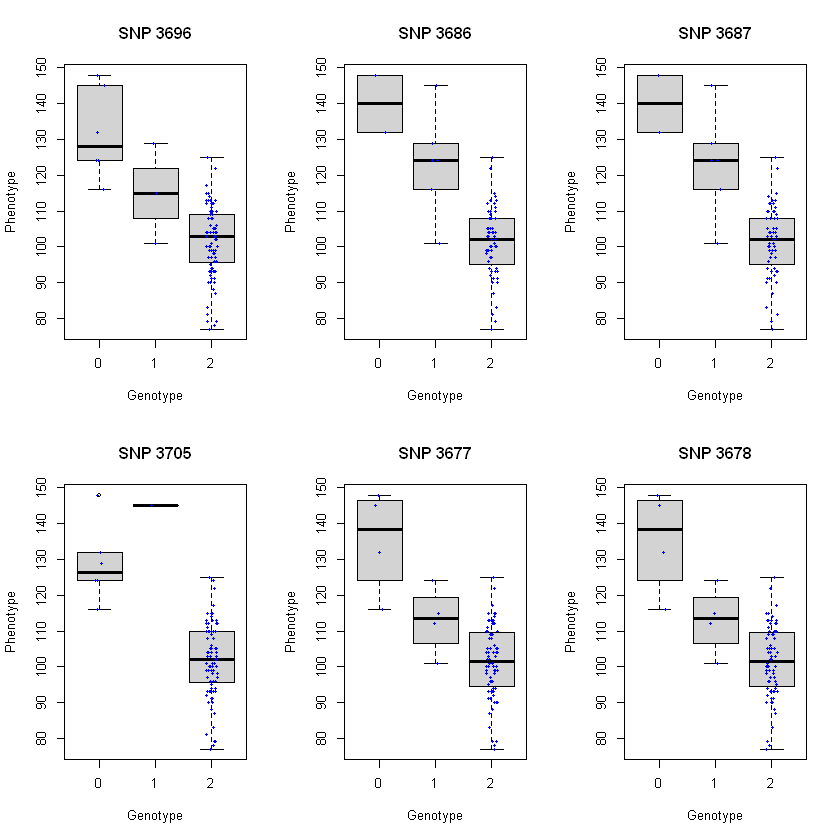

In [15]:
top_snps <- c("3696", "3686", "3687", "3705", "3677", "3678")

par(mfrow = c(2, 3))  
for (snp in top_snps) {
  snp_geno <- as.factor(geno.df[[snp]])
  boxplot(y ~ snp_geno,
          main = paste("SNP", snp),
          xlab = "Genotype", ylab = "Phenotype")
  stripchart(y ~ snp_geno,
             vertical = TRUE, method = "jitter", add = TRUE, pch = 20, col = "blue")
}
par(mfrow = c(1, 1))


In [16]:
chr7_df <- subset(manhattan_df, CHR == 7)


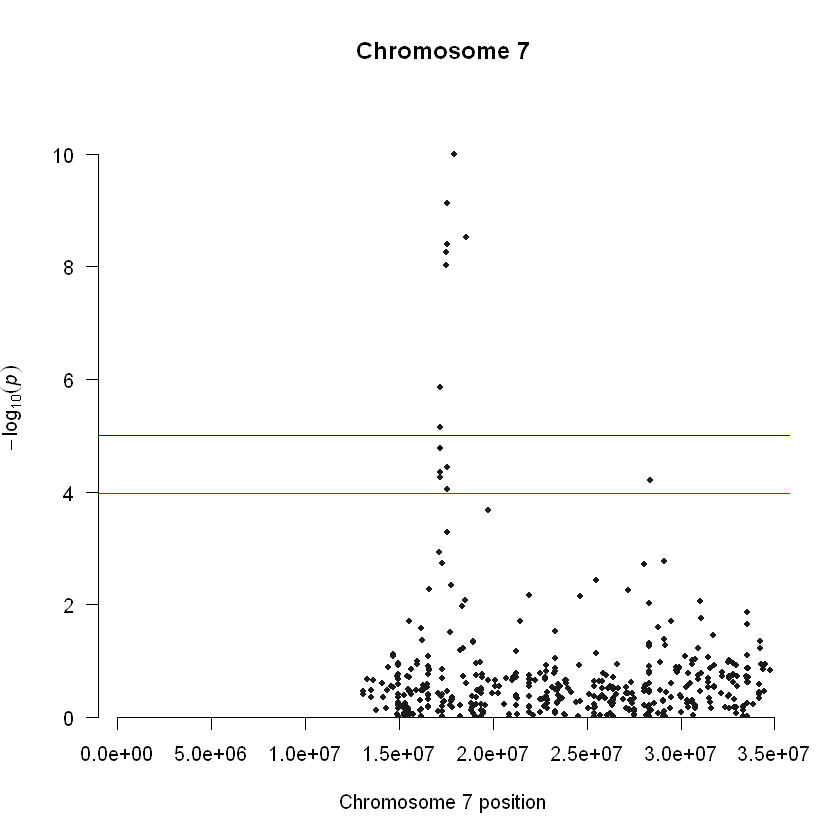

In [20]:
manhattan(chr7_df,
          chr = "CHR", bp = "BP", snp = "SNP", p = "pvalue",
          main = "Chromosome 7",
          genomewideline = -log10(0.05 / nrow(chr7_df)),
          suggestiveline = -log10(1e-5),
          ylim = c(0, max(chr7_df$logP) + 1))

In [18]:
top_chr7 <- chr7_df[order(chr7_df$pvalue), ][1:5, ]
print(top_chr7)

      SNP      beta       pvalue     logP CHR       BP
4581 3696 -14.86185 1.017392e-10 9.992512   7 17902694
4570 3686 -20.32327 7.338871e-10 9.134371   7 17562245
4571 3687 -20.32327 7.338871e-10 9.134371   7 17562357
4592 3705 -14.69753 2.969701e-09 8.527287   7 18593304
4560 3677 -15.92187 3.968079e-09 8.401420   7 17555583


Регион 17.5–18.5 Mb на 7-й хромосоме содержит один или несколько генов/регуляторных элементов, оказывающих сильное влияние на урожаемость. Далее можно посмотреть на участок этой хромосомы и делать дальнейший анализ.

In [5]:
geno.df$sample <- rownames(geno.df)
write.csv(geno.df, "geno_matrix.csv", row.names = FALSE)

In [6]:
write.csv(phenos.filtered, "phenotypes.csv", row.names = FALSE)


## Модель предсказания

Ядро -  python3

In [16]:
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import KNNImputer 

geno = pd.read_csv("geno_matrix.csv")
pheno = pd.read_csv("phenotypes.csv")
gwas = pd.read_csv("gwas_results_with_coordinates.csv")

significant_snps = gwas[gwas["pvalue"] < 0.01]["SNP"].astype(str)
geno_filtered = geno[geno.columns.intersection(significant_snps.tolist() + ["sample"])]

merged = pd.merge(pheno, geno_filtered, on="sample")

X = merged.drop(columns=["sample", "phenotype"])
y = merged["phenotype"]

imputer = KNNImputer(n_neighbors=5)  
X_imputed = imputer.fit_transform(X)  

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


R²: 0.517
RMSE: 8.419


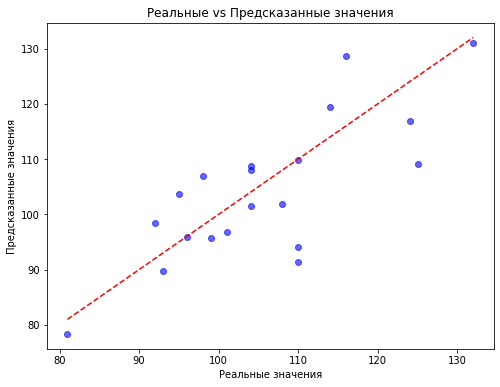

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Реальные vs Предсказанные значения')
plt.show()


Очень маленький процент предсказания.

In [20]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

y_lr_pred = lr_model.predict(X_test)

r2_lr = r2_score(y_test, y_lr_pred)
rmse_lr = mean_squared_error(y_test, y_lr_pred, squared=False)

print(f"Линейная регрессия R²: {r2_lr:.3f}")
print(f"Линейная регрессия RMSE: {rmse_lr:.3f}")


Линейная регрессия R²: 0.478
Линейная регрессия RMSE: 8.755


Линейная регрессия работает хуже.

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=42)

gb_model.fit(X_train, y_train)

y_gb_pred = gb_model.predict(X_test)

r2_gb = r2_score(y_test, y_gb_pred)
rmse_gb = mean_squared_error(y_test, y_gb_pred, squared=False)

print(f"Градиентный бустинг R²: {r2_gb:.3f}")
print(f"Градиентный бустинг RMSE: {rmse_gb:.3f}")


Градиентный бустинг R²: 0.402
Градиентный бустинг RMSE: 9.375


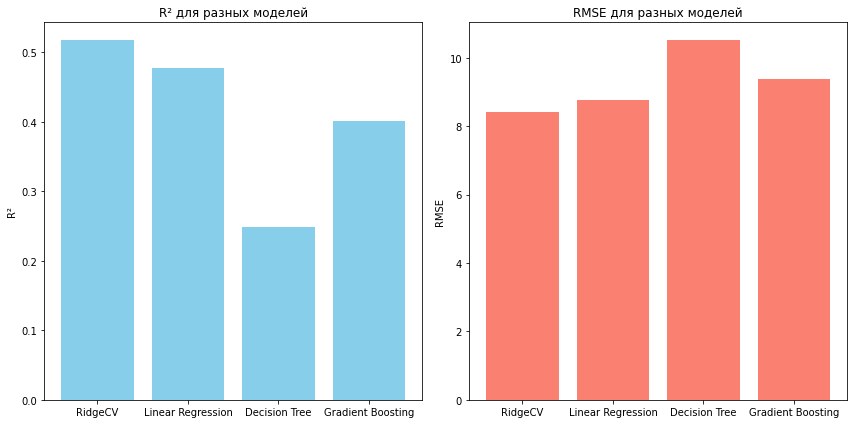

In [23]:
import matplotlib.pyplot as plt

models = ['RidgeCV', 'Linear Regression', 'Decision Tree', 'Gradient Boosting']
r2_scores = [r2, r2_lr, r2_dt, r2_gb]
rmse_scores = [rmse, rmse_lr, rmse_dt, rmse_gb]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(models, r2_scores, color='skyblue')
plt.title("R² для разных моделей")
plt.ylabel("R²")

plt.subplot(1, 2, 2)
plt.bar(models, rmse_scores, color='salmon')
plt.title("RMSE для разных моделей")
plt.ylabel("RMSE")

plt.tight_layout()
plt.show()


Для улучшения модели нужно создавать новые признаки, возможно приводить их к разному виду и группировкам. Также подбирать гиперпараметры в моделях, перебирать возможные и смотреть, чтобы модель не переобучалась.

## Улучшения

Для улучшения качества предсказательной модели можно интегрировать дополнительные данные, такие как погодные условия (температура, осадки, влажность) и характеристики почвы (тип, pH, содержание элементов). Эти данные оказывают значительное влияние на рост и урожайность культур, и их добавление в модель позволит повысить точность предсказаний. Погодные данные можно собрать с помощью API (например, OpenWeatherMap), а данные о почве интегрировать с использованием GPS-координат для каждого поля.

Для автоматизации процесса анализа данных и предсказания фенотипов целесообразно использовать инструменты, такие как Apache Airflow или MLflow, которые позволят создавать пайплайны для загрузки, обработки данных, обучения модели и предсказания. Такой подход обеспечит повторяемость и масштабируемость процессов, а также позволит автоматически обновлять модель с новыми данными. Использование Docker-контейнеров для упаковки этапов пайплайна и их развертывание в Kubernetes гарантирует удобство и гибкость работы с большими объемами данных.